# Smart Shelves.
## Problem Statement : Detect various products in the shelf and count the number of products. If the count is less than a threshold value we have to send an alert (via emial).
### We are using YoloV5 algorithm for the object detection and counting of various products.

#### 1. We need to clone the Repository of the official YoloV5 from Github. We are going to train the YoloV5 algorithm with our custom dataset.

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 13342, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 13342 (delta 104), reused 128 (delta 91), pack-reused 13198
Receiving objects: 100% (13342/13342), 13.22 MiB | 14.85 MiB/s, done.
Resolving deltas: 100% (9168/9168), done.
/content/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


#### 2. Installing the necessary requirements for training YoloV5

In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 1.6 MB 26.6 MB/s 
Setup complete. Using torch 1.12.1+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


#### 3. Loading the Dataset. We have combined different datasets of Egg, Coffee, Beans, Drinks and Detergent. The creation of dataset was with the help of [Roboflow](https://roboflow.com).

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="eehE26n2j00NQElG8Aag")
project = rf.workspace("tech-ebzgy").project("egg-coffee-beans-drinks-detergent")
dataset = project.version(1).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 40.4 MB/s 
     |████████████████████████████████| 178 kB 41.9 MB/s 
     |████████████████████████████████| 1.1 MB 67.1 MB/s 
     |████████████████████████████████| 67 kB 6.3 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 138 kB 66.6 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Created wheel for roboflow: filename=roboflow-0.2.15-py3-none-any.whl size=24936 sha256=40277d8bb5c10689ce9504e9b806e3ab3f7ff89b00caaa9dbd604728be7c8227
  Stored in directory: /root/.cache/pip/wheels/13/e0/a3/fe183fffc3972cb9264e800763d4bbfff80d5309137c410217
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=b4f3ef8c41215ba15cccb71ea1c85571bb65ddd99bb8697378b4696a83ed3ab3
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Egg-Coffee-Beans-Drinks-Detergent-1 in yolov5pytorch:: 100%|██████████| 2502/2502 [00:01<00:00, 2272.30it/s]


In [ ]:
%cd /content/yolov5

/content/yolov5


In [ ]:
# this is the YAML file from roboflow.
%cat {dataset.location}/data.yaml

names:
- Beans
- Coffee
- Detergent
- Drinks
- Egg
nc: 5
train: Egg-Coffee-Beans-Drinks-Detergent-1/train/images
val: Egg-Coffee-Beans-Drinks-Detergent-1/valid/images


In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])
num_classes

'5'

In [ ]:
#this is the model configuration 
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

#### We have configured the YoloV5 model. We will be using this for training our dataset.

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights " " --name yolov5s_results  --cache

/content/yolov5
train: weights= , cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/Egg-Coffee-Beans-Drinks-Detergent-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 281 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup

#### 4. Comparing our labeled images and predicted images from validation set.

#### Labelled

GROUND TRUTH TRAINING DATA:


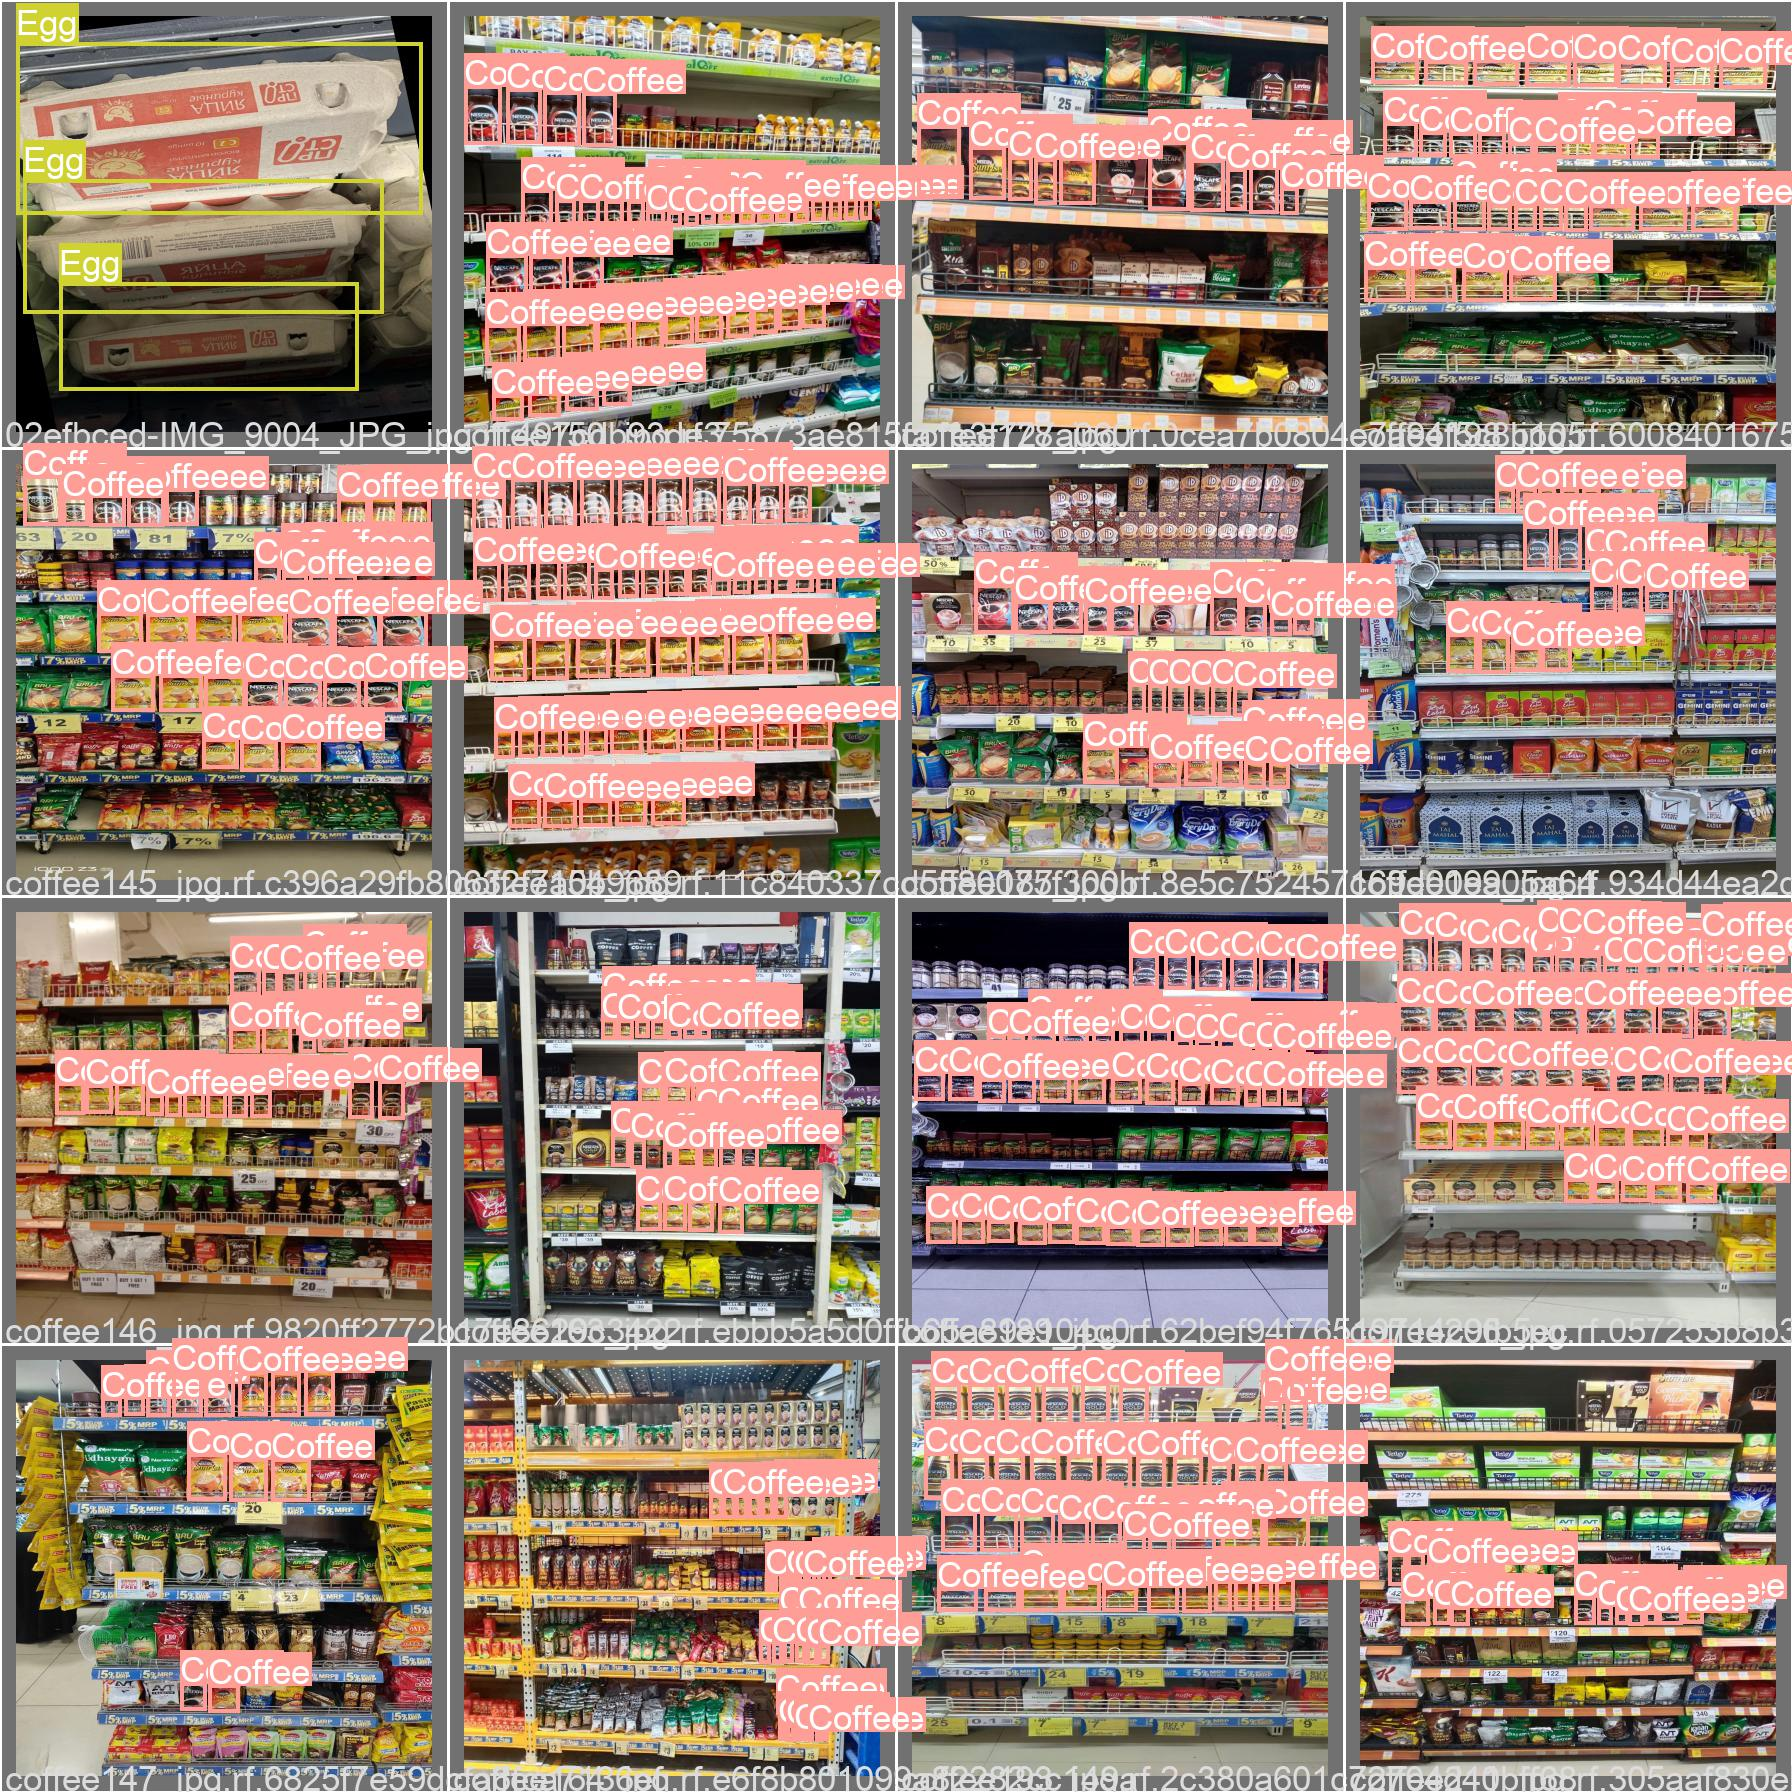

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

#### Predicted

GROUND TRUTH AUGMENTED TRAINING DATA:


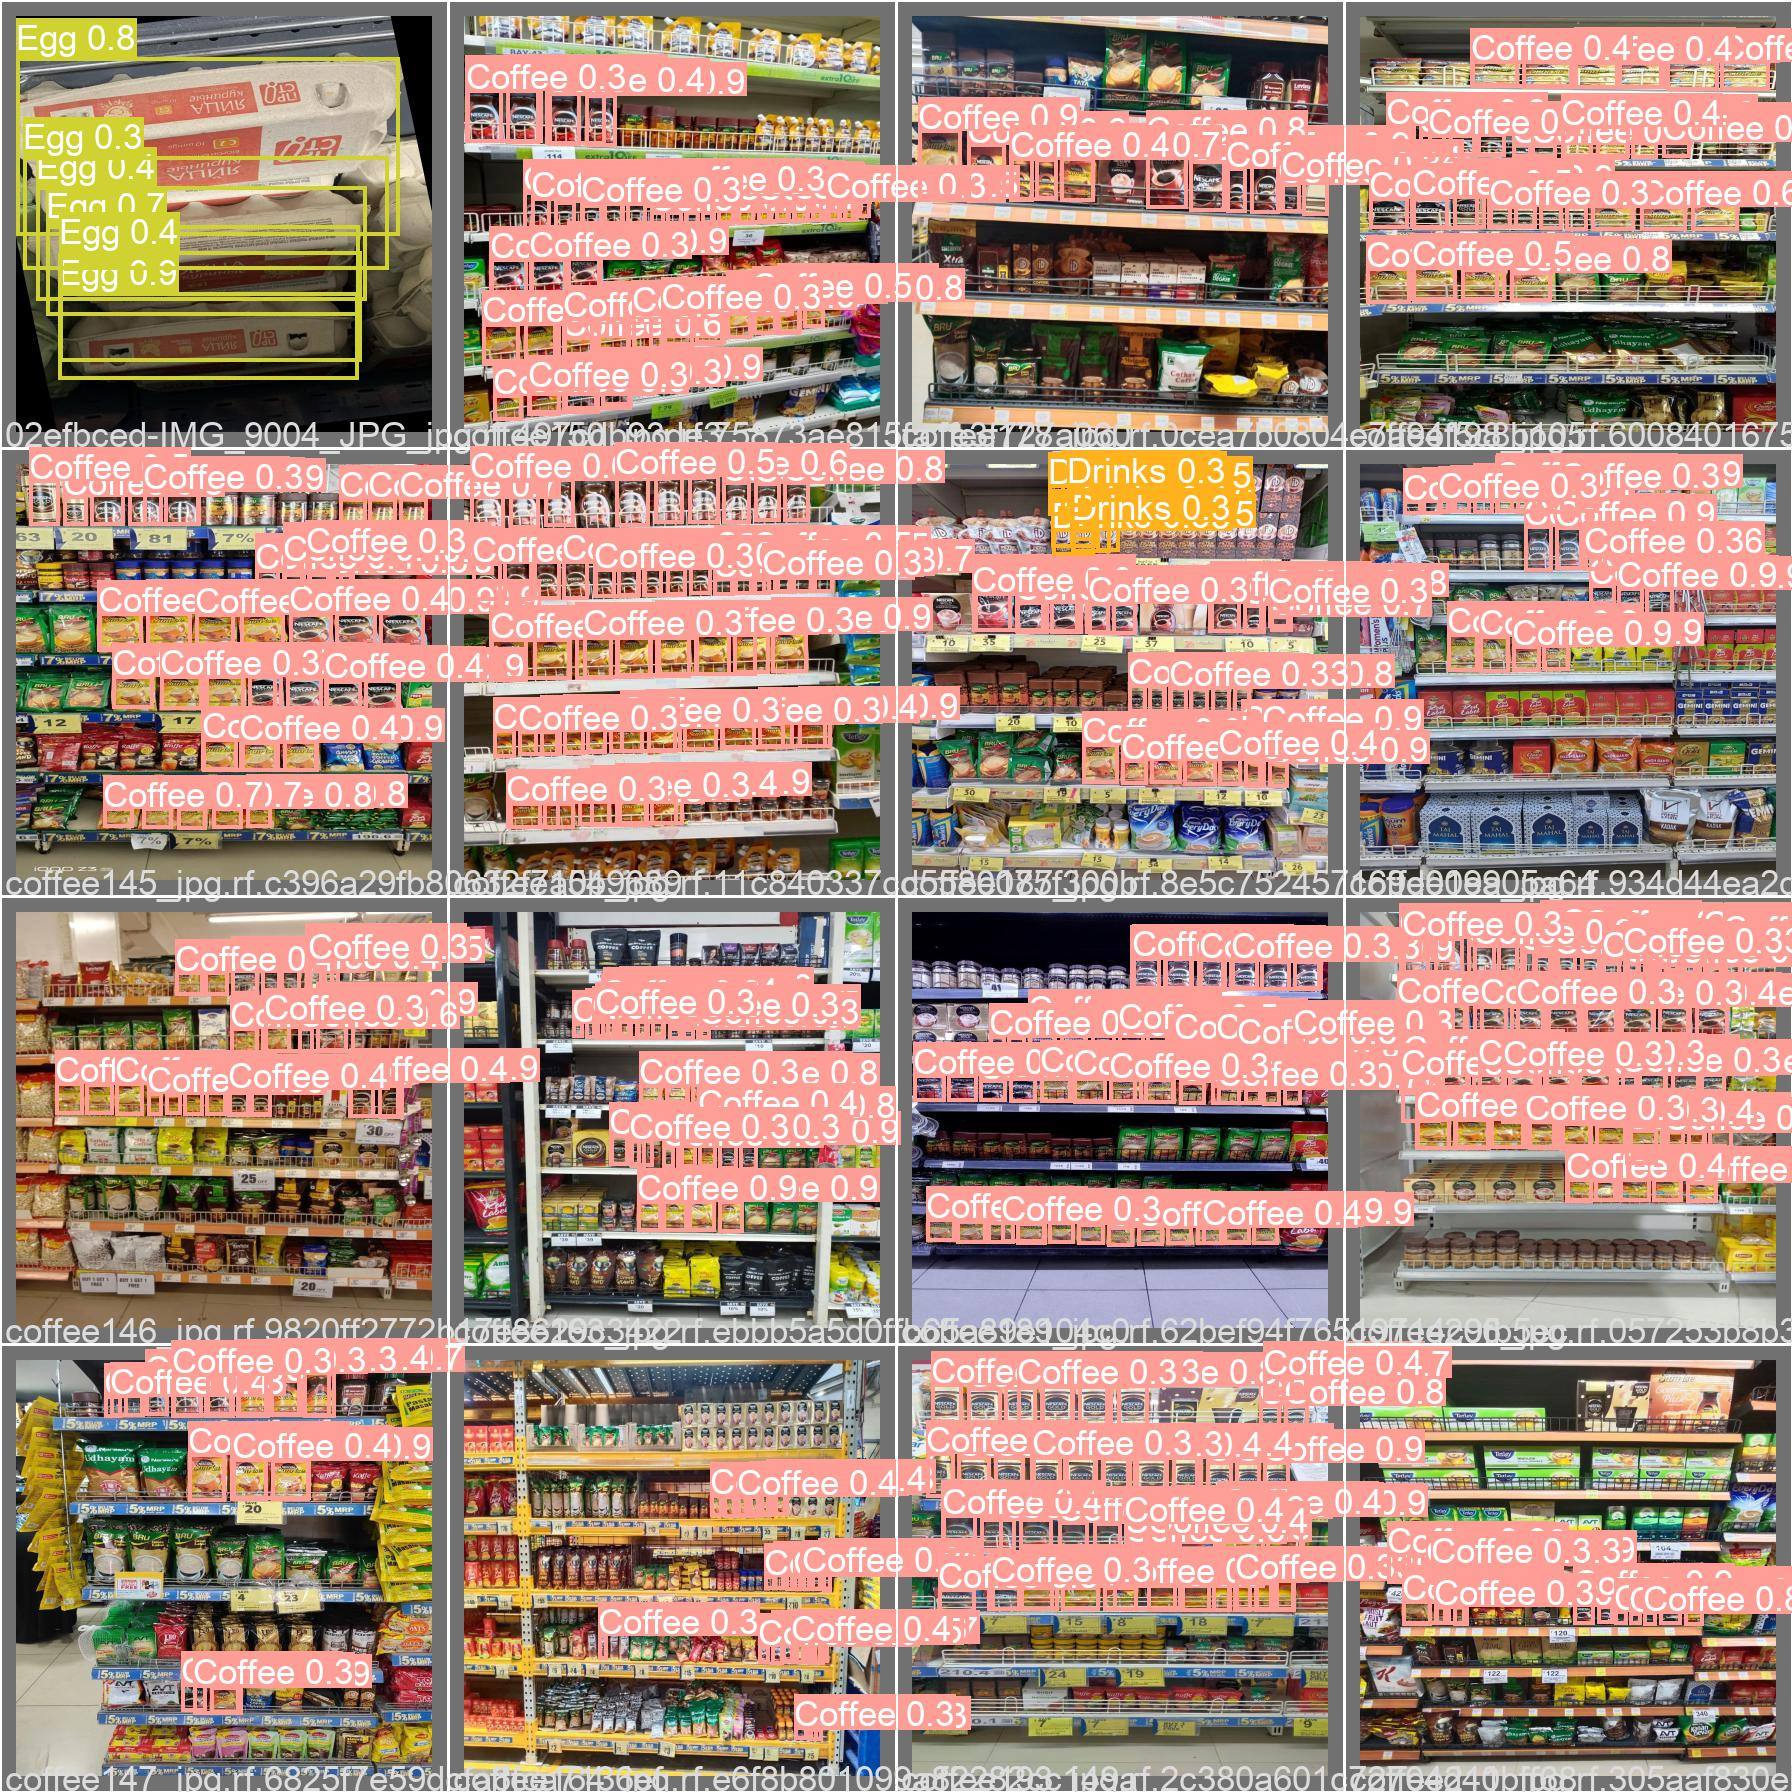

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_pred.jpg', width=900)

#### 5. Saving our trained weights.

In [ ]:
# trained weights are saved by default in our weights folder
%cd runs/


[Errno 2] No such file or directory: 'runs/'
/content/yolov5


In [ ]:
%ls train/yolov5s_results/weights

ls: cannot access 'train/yolov5s_results/weights': No such file or directory


#### Using detect.py and our trained weights we can detect the objects in the test dataset. This code will save the outputs.

In [ ]:

%cd /content/yolov5/
!python detect.py --weights /content/best.pt --img 416 --conf 0.4 --source ../yolov5/Egg-Coffee-Beans-Drinks-Detergent-1/test/images



/content/yolov5
detect: weights=['/content/best.pt'], source=../yolov5/Egg-Coffee-Beans-Drinks-Detergent-1/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 232 layers, 7257306 parameters, 0 gradients, 16.8 GFLOPs
image 1/124 /content/yolov5/Egg-Coffee-Beans-Drinks-Detergent-1/test/images/03252d74-IMG_9153_JPG_jpg.rf.4ac7bc46c10a5315930f31b138da1b6a.jpg: 416x416 10 Eggs, Done. (0.014s)
image 2/124 /content/yolov5/Egg-Coffee-Beans-Drinks-Detergent-1/test/images/0765caa7-IMG_9006_JPG_jpg.rf.96f6906e7222d3068389d491271a224c

### 7. Testing our model on the single image and building an email alert system.

In [ ]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import PIL

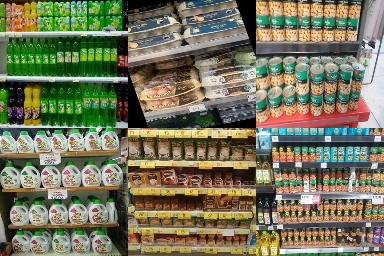

In [ ]:
im = PIL.Image.open("/content/test_img.png")
im

#### For counting the products in an image first we need to load our model using pytorch.

In [ ]:
import pandas as pd
model = torch.hub.load('/content/yolov5/', 'custom', path='/content/best.pt', source='local')
# #pip install Pillow
# model("/content/test-imresizer.jpg")
results = model("/content/test_img.png")
results.save(save_dir="/content")

INFO:yolov5:requirements: matplotlib>=3.2.2 not found and is required by YOLOv5, attempting auto-update...
requirements: matplotlib>=3.2.2 not found and is required by YOLOv5, attempting auto-update...
INFO:yolov5:Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

INFO:yolov5:requirements: requests>=2.23.0 not found and is required by YOLOv5, attempting auto-update...
requirements: requests>=2.23.0 not found and is required by YOLOv5, attempting auto-update...
INFO:yolov5:Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

INFO:yolov5:requirements: seaborn>=0.11.0 not found and is required by YOLOv5, attempting auto-update...
requirements: seaborn>=0.11.0 not found and is required by YOLOv5, at

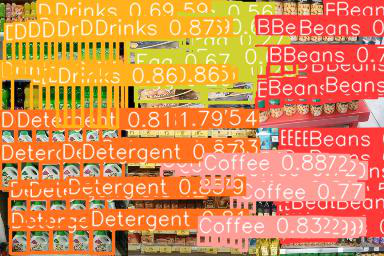

In [ ]:
im = PIL.Image.open("/content/test_img.jpg")
im

In [ ]:
# Creating a dataframe to store the count.
count_of_each_obj = results.pandas().xyxy[0].value_counts('name')

Prod_Count = pd.DataFrame(count_of_each_obj, columns=[ "Count"])
prod_list = Prod_Count.index.to_list()
print(Prod_Count)

           Count
name            
Beans         90
Drinks        39
Detergent     23
Coffee        20
Egg           12


### Creating an Email alert system using smtplib. 
We can set our own threshold for comparing the count.  

In [ ]:
import smtplib
from email.message import EmailMessage

#df = pd.DataFrame({'Latitude': [11.324342,343.4552,434.3, 'nan',-34895.6661,1,2], 'Longtitude': list('ABCDEFG'), 'LocationKey': [38.676943448,-38.6769438,34,23,12,56,67]})

def email_alert(subject,body,to):
    msg = EmailMessage()
    msg.set_content(body)
    msg['subject'] = subject
    msg['to'] = to
        
    user = "smartshelfproject@gmail.com"
    msg['from'] = user
    password = "siwnvhnortimfmth"
        
    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.starttls()
    server.login(user,password)
    server.send_message(msg)
    server.quit()

if __name__ == '__main__':
  threshold = 100 # only using 100 to test our model. 
  body_1 = "Dear Sir,\n\nThe following are the products to be restocked.\n\n"
  body_3 = "\nPlease do the needful.\n\nThanks and Regards,\nSmart Shelves"
  body_2 = ""
  counter = 1
  for prod in prod_list:
    count = Prod_Count._get_value(prod, "Count")
    if count<threshold:
      body_2+= f"{counter}. {prod} only {count} left. \n"
      counter+=1
  if body_2:
    body = body_1 + body_2 + body_3
    #print(body)
    email_alert("Low stock alert! ",body,"sriganesshh10@gmail.com.com")
    print("Email sent")
  else:
    print("No need to send the email")